# Random Forest Model

In [64]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [65]:
def f3(img_path, size=(128, 128), dct=True, kernel_size=(5, 5)):
    img = cv2.imread(img_path, 0)  # Load image as grayscale
    if img is None:
        print(f"Warning: Unable to read image at {img_path}")
        return None  # Return None if the image cannot be read

    img = cv2.resize(img, size)  # Resize image

    # Apply Gaussian Smoothing
    img = cv2.GaussianBlur(img, kernel_size, 0)
    if dct:
        img = cv2.dct(np.float32(img))  # Apply DCT
    
        if np.max(img) != np.min(img):  # Prevent division by zero
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
        else:
            img = img / 255.0  # Default normalization if range is zero

    img = img.flatten()  # Flatten the image
    return img

In [66]:
# Load the labels
labels_df = pd.read_csv('../labels.csv')

X = []  # Feature vectors
y = []  # Labels

# Load images and preprocess them
for i, row in labels_df.iterrows():
    img_path = os.path.join('../images', row['Filename'])
    img_preprocessed = f3(img_path)
    X.append(img_preprocessed)
    y.append(row['Label'])

X = np.array(X)
y = np.array(y)


### Undersampling

In [67]:
# Count the number of samples per class
class_counts = Counter(y)
print("Class distribution before undersampling:", class_counts)

# Identify the majority class (negative species)
majority_class = 8

# Indices of samples in the majority and minority classes
majority_indices = np.where(y == majority_class)[0]
minority_indices = np.where(y != majority_class)[0]

# Undersample the majority class
np.random.seed(42)
undersample_size = 1000
undersampled_majority_indices = np.random.choice(majority_indices, size=undersample_size, replace=False)

# Combine undersampled majority indices with all minority class indices
balanced_indices = np.concatenate([undersampled_majority_indices, minority_indices])

# Shuffle the balanced indices
balanced_indices = shuffle(balanced_indices, random_state=42)

# Create balanced X and y
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

# Verify the new class distribution
new_class_counts = Counter(y_balanced)
print("Class distribution after undersampling:", new_class_counts)

Class distribution before undersampling: Counter({np.int64(8): 9106, np.int64(0): 1125, np.int64(6): 1074, np.int64(1): 1064, np.int64(4): 1062, np.int64(2): 1031, np.int64(3): 1022, np.int64(7): 1016, np.int64(5): 1009})
Class distribution after undersampling: Counter({np.int64(0): 1125, np.int64(6): 1074, np.int64(1): 1064, np.int64(4): 1062, np.int64(2): 1031, np.int64(3): 1022, np.int64(7): 1016, np.int64(5): 1009, np.int64(8): 1000})


### Data Splitting

In [68]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

### Standardize the Data

In [69]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Data Preprocessing (PCA)


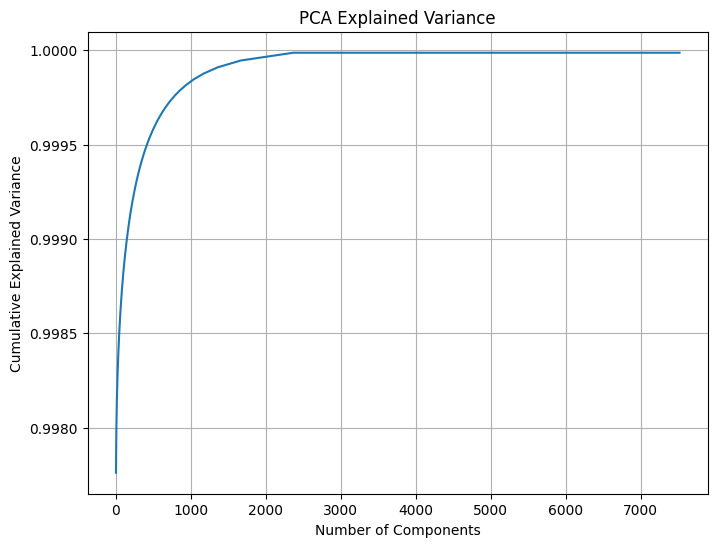

In [70]:
import matplotlib.pyplot as plt

pca_full = PCA().fit(X_train_scaled)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [71]:
from sklearn.decomposition import PCA

# Apply PCA to retain 2500 features
pca = PCA(n_components=2500, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Original number of features: {X_train_scaled.shape[1]}')
print(f'Reduced number of features after PCA: {X_train_pca.shape[1]}')

Original number of features: 16384
Reduced number of features after PCA: 2500


### Model Training


In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

k_values = [1, 3, 5, 7, 9, 11, 13, 15]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_pca, y_train)
    y_pred_knn = knn.predict(X_test_pca)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    print(f'kNN Accuracy with k={k}: {accuracy_knn:.4f}')
    # print(classification_report(y_test, y_pred_knn))

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    cv_scores = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f'Average CV Accuracy for kNN with k={k}: {cv_scores.mean():.4f}')

kNN Accuracy with k=1: 0.1116
kNN Accuracy with k=3: 0.1159
kNN Accuracy with k=5: 0.1233
kNN Accuracy with k=7: 0.1249
kNN Accuracy with k=9: 0.1196
kNN Accuracy with k=11: 0.1175
kNN Accuracy with k=13: 0.1143
kNN Accuracy with k=15: 0.1138
Average CV Accuracy for kNN with k=1: 0.1211
Average CV Accuracy for kNN with k=3: 0.1211
Average CV Accuracy for kNN with k=5: 0.1248
Average CV Accuracy for kNN with k=7: 0.1215
Average CV Accuracy for kNN with k=9: 0.1208
Average CV Accuracy for kNN with k=11: 0.1242
Average CV Accuracy for kNN with k=13: 0.1228
Average CV Accuracy for kNN with k=15: 0.1238


In [73]:
from sklearn.model_selection import GridSearchCV

param_grid_knn = {
    'n_neighbors': k_values,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier(n_jobs=-1)
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_pca, y_train)

print("Best parameters for kNN:", grid_search_knn.best_params_)
print(f"Best CV Accuracy for kNN: {grid_search_knn.best_score_:.4f}")

# Evaluate on test set
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Test Accuracy for best kNN: {accuracy_knn:.4f}')
print("Classification Report for best kNN:")
print(classification_report(y_test, y_pred_knn))

Best parameters for kNN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best CV Accuracy for kNN: 0.1248
Test Accuracy for best kNN: 0.1233
Classification Report for best kNN:
              precision    recall  f1-score   support

           0       0.19      0.06      0.09       225
           1       0.07      0.01      0.02       213
           2       0.12      0.09      0.10       206
           3       0.17      0.00      0.01       204
           4       0.05      0.00      0.01       213
           5       0.33      0.00      0.01       202
           6       0.11      0.64      0.19       215
           7       0.14      0.00      0.01       203
           8       0.15      0.29      0.20       200

    accuracy                           0.12      1881
   macro avg       0.15      0.12      0.07      1881
weighted avg       0.15      0.12      0.07      1881



In [74]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)

# Evaluation Metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.20
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.20      0.24      0.22       225
           1       0.17      0.19      0.18       213
           2       0.18      0.24      0.21       206
           3       0.14      0.15      0.15       204
           4       0.16      0.18      0.17       213
           5       0.19      0.09      0.13       202
           6       0.39      0.47      0.42       215
           7       0.19      0.13      0.15       203
           8       0.18      0.12      0.14       200

    accuracy                           0.20      1881
   macro avg       0.20      0.20      0.20      1881
weighted avg       0.20      0.20      0.20      1881

